In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import torch.optim as optim

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def load_graph(file_path):
    edgelist = []
    set_a = []
    set_b = []

    with open(file_path) as f:
        for ind, line in enumerate(f):
            if ind == 0: 
                na, nb, ns = map(int, line.split('\t'))
                set_b = [f"set_b_{i}" for i in range(nb)]
                set_a = [f"set_a_{i}" for i in range(na)]
                continue
            a, b, s = map(int, line.split('\t'))
            if s == 1:
                edgelist.append((f"set_a_{a}", f"set_b_{b}", {'sign': '+1'}))
            else:
                edgelist.append((f"set_a_{a}", f"set_b_{b}", {'sign': '-1'}))

    B = nx.Graph()
    B.add_nodes_from(set_a, bipartite=0)
    B.add_nodes_from(set_b, bipartite=1)
    B.add_edges_from(edgelist)
    
    return B

In [14]:
def build_drawing(B, set_a, set_b):
    pos = nx.spring_layout(B)

    # Draw nodes with different shapes based on their bipartite attribute
    nx.draw_networkx_nodes(B, pos, nodelist=set_a, node_shape='o')
    nx.draw_networkx_nodes(B, pos, nodelist=set_b, node_shape='s')

    # Determine edge colors based on edge attributes
    edge_colors = ['blue' if attrs['sign'] == '+1' else 'red' for u, v, attrs in B.edges(data=True)]

    # Draw edges
    nx.draw_networkx_edges(B, pos, edge_color=edge_colors)


    plt.legend()
    plt.show()

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class SBGNN(nn.Module):
    def __init__(self, graph, emb_dim_a=32, emb_dim_b=32):
        super(SBGNN, self).__init__()

        self.graph = graph
        self.set_a = [n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 0]
        self.set_b = [n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 1]
        self.emb_dim_a = emb_dim_a
        self.emb_dim_b = emb_dim_b

        # Initialize ParameterDict for features_a and features_b
        self.features_a = nn.ParameterDict({str(node): nn.Parameter(torch.randn(1, self.emb_dim_a)) for node in self.set_a})
        self.features_b = nn.ParameterDict({str(node): nn.Parameter(torch.randn(1, self.emb_dim_b)) for node in self.set_b})
        self.new_features_a= nn.ParameterDict({str(node): nn.Parameter(torch.randn(1, self.emb_dim_a)) for node in self.set_a})
        self.new_features_b = nn.ParameterDict({str(node): nn.Parameter(torch.randn(1, self.emb_dim_b)) for node in self.set_b})

        self.weight_a_b = nn.Parameter(torch.randn(self.emb_dim_a, self.emb_dim_a))
        self.weight_a_u = nn.Parameter(torch.randn(self.emb_dim_a, self.emb_dim_a))
        self.weight_b_b = nn.Parameter(torch.randn(self.emb_dim_b, self.emb_dim_b))
        self.weight_b_u = nn.Parameter(torch.randn(self.emb_dim_b, self.emb_dim_b))

        self.mlp_a = MLP(3 * self.emb_dim_a, self.emb_dim_a)
        self.mlp_b = MLP(3 * self.emb_dim_b, self.emb_dim_b)

    def message_passing(self, iterations=1):
        for i in range(iterations):
            new_features_a = {}
            new_features_b = {}

            for node in self.set_a:
                new_features_a_b = torch.zeros(self.emb_dim_a, device=self.features_a[str(node)].device)
                new_features_a_u = torch.zeros(self.emb_dim_a, device=self.features_a[str(node)].device)
                count_b = 0
                count_u = 0

                for neighbor in self.graph.neighbors(node):
                    sign = self.graph.edges[node, neighbor]['sign']
                    if sign == '+1':
                        new_features_a_b += self.features_b[str(neighbor)].squeeze(0)
                        count_b += 1
                    else:
                        new_features_a_u += self.features_b[str(neighbor)].squeeze(0)
                        count_u += 1

                if count_b > 0:
                    new_features_a_b /= count_b
                    new_features_a_b = torch.matmul(new_features_a_b, self.weight_a_b)

                if count_u > 0:
                    new_features_a_u /= count_u
                    new_features_a_u = torch.matmul(new_features_a_u, self.weight_a_u)

                new_features_a[str(node)] = torch.cat((new_features_a_b, new_features_a_u, self.features_a[str(node)].squeeze(0)), dim=0)
                new_features_a[str(node)] = self.mlp_a(new_features_a[str(node)])
                new_features_a[str(node)] = nn.Parameter(new_features_a[str(node)])

            for node in self.set_b:
                new_features_b_b = torch.zeros(self.emb_dim_b, device=self.features_b[str(node)].device)
                new_features_b_u = torch.zeros(self.emb_dim_b, device=self.features_b[str(node)].device)
                count_b = 0
                count_u = 0

                for neighbor in self.graph.neighbors(node):
                    sign = self.graph.edges[node, neighbor]['sign']
                    if sign == '+1':
                        new_features_b_b += self.features_a[str(neighbor)].squeeze(0)
                        count_b += 1
                    else:
                        new_features_b_u += self.features_a[str(neighbor)].squeeze(0)
                        count_u += 1

                if count_b > 0:
                    new_features_b_b /= count_b
                    new_features_b_b = torch.matmul(new_features_b_b, self.weight_b_b)

                if count_u > 0:
                    new_features_b_u /= count_u
                    new_features_b_u = torch.matmul(new_features_b_u, self.weight_b_u)

                new_features_b[str(node)] = torch.cat((new_features_b_b, new_features_b_u, self.features_b[str(node)].squeeze(0)), dim=0)
                new_features_b[str(node)] = self.mlp_b(new_features_b[str(node)])
                new_features_b[str(node)] = nn.Parameter(new_features_b[str(node)])

            # Update ParameterDicts
            for node in self.set_a:
                self.new_features_a[str(node)] = new_features_a[str(node)].unsqueeze(0)

            for node in self.set_b:
                self.new_features_b[str(node)] = new_features_b[str(node)].unsqueeze(0)



In [16]:
class Softmax(nn.Module):
    def __init__(self, input_dim, cluster_number):
        super(Softmax, self).__init__()
        self.fc = nn.Linear(input_dim, cluster_number)  

    def forward(self, x):
        x = self.fc(x)         
        x = F.softmax(x, dim=0) 
        return x


In [17]:
class Community(nn.Module):
    def __init__(self, sbgnn, cluster_number):
        super(Community, self).__init__()
        
        self.sbgnn=sbgnn
        self.cluster_number=cluster_number
        self.emb_dim_a=self.sbgnn.emb_dim_a
        self.emb_dim_b=self.sbgnn.emb_dim_b

        self.Softmax_a=Softmax(self.emb_dim_a,self.cluster_number)
        self.Softmax_b=Softmax(self.emb_dim_b,self.cluster_number)


    def build_communities(self):
        self.list_a=[]
        self.list_b=[]
        
        for node in self.sbgnn.set_a:
            new_tensor=self.sbgnn.new_features_a[str(node)].squeeze(0)
            new_tensor=self.Softmax_a(new_tensor)
            self.list_a.append(new_tensor)
        
        self.C_a=torch.stack(self.list_a,dim=0).squeeze(0)
        self.C_a=self.C_a.to(dtype=torch.float64)


        for node in self.sbgnn.set_b:
            new_tensor=self.sbgnn.new_features_b[str(node)].squeeze(0)
            new_tensor=self.Softmax_b(new_tensor)
            self.list_b.append(new_tensor)
        
        self.C_b=torch.stack(self.list_b,dim=0).squeeze(0)
        self.C_b=self.C_b.to(dtype=torch.float64)

In [18]:
class Modularity(nn.Module):
    def __init__(self,sbgnn,community):
        super(Modularity, self).__init__()

        self.graph=sbgnn.graph
        self.set_a = sbgnn.set_a
        self.set_b = sbgnn.set_b
        self.n=len(self.set_a)
        self.m=len(self.set_b)

        self.community=community
        self.C_a=self.community.C_a
        self.C_b=self.community.C_b
        self.k=self.community.cluster_number

        self.positive_counts={node:0 for node in self.graph.nodes()}
        self.negative_counts={node:0 for node in self.graph.nodes()}
        self.total_positive=0
        self.total_negative=0


    def build_adjacency_matrix(self):
        matrix = np.zeros((self.n, self.m))
        for i, a_node in enumerate(self.set_a):
            for j, b_node in enumerate(self.set_b):
                if self.graph.has_edge(a_node, b_node) and self.graph[a_node][b_node]['sign']=='+1':
                    matrix[i, j] = 1
                elif self.graph.has_edge(a_node, b_node) and self.graph[a_node][b_node]['sign']=='-1':
                    matrix[i,j] = -1
        self.adj_matrix=torch.from_numpy(matrix).to(device)


    def count_edges(self):
        for u, v, data in self.graph.edges(data=True):
            if data['sign'] =='+1':
                self.positive_counts[u] += 1
                self.positive_counts[v] += 1
                self.total_positive+=1
            elif data['sign'] =='-1':
                self.negative_counts[u] += 1
                self.negative_counts[v] += 1
                self.total_negative+=1
        
        self.positive_plus_negative=self.total_positive+self.total_negative
    
    def build_W_matrix(self):
        matrix=[]
        for node_i in self.set_a:
            temp_list=[]
            for node_j in self.set_b:
                pos=(self.positive_counts[node_i]*self.positive_counts[node_j])/self.total_positive
                neg=(self.negative_counts[node_i]*self.negative_counts[node_j])/self.total_negative
                temp_list.append(pos-neg)
            matrix.append(temp_list)
        matrix=np.matrix(matrix)
        matrix = self.adj_matrix.cpu().numpy() - matrix
        self.W_matrix=torch.from_numpy(matrix).to(device)

    def find_modularity(self):
        denominator=1/self.positive_plus_negative
        final_matrix= torch.matmul(self.C_a.t(),self.W_matrix)
        self.final_matrix=torch.matmul(final_matrix,self.C_b)
        self.trace=torch.trace(self.final_matrix)
        self.modularity=denominator*self.trace


    def loss_function(self):

        self.soft_count_a=torch.sum(self.C_a,dim=0)
        self.soft_count_b=torch.sum(self.C_b,dim=0)

        self.frobenius_norm_a=torch.norm(self.soft_count_a,p='fro')
        self.frobenius_norm_b=torch.norm(self.soft_count_b,p='fro')

        self.reg_a=(np.sqrt(self.k)/self.n)*self.frobenius_norm_a
        self.reg_b=(np.sqrt(self.k)/self.m)*self.frobenius_norm_b

        self.regularization=self.reg_a+self.reg_b -2

        self.loss= self.regularization-self.modularity 

In [19]:
def train_sbgnn(sbgnn, community, lr=0.1, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    sbgnn.to(device)
    community.to(device)
    all_params = set(sbgnn.parameters()) | set(community.parameters())
    
    # Create optimizer
    modularity_values = []
    optimizer = optim.Adam(all_params, lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        sbgnn.message_passing(iterations=1)
        community.build_communities()
        modularity=Modularity(sbgnn,community)
        modularity.to(device)
        modularity.build_adjacency_matrix()
        modularity.count_edges()
        modularity.build_W_matrix()
        modularity.find_modularity()
        modularity.loss_function()

        
        loss = modularity.loss
        loss.backward()
        optimizer.step()
        modularity_values.append(modularity.modularity.item())
        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            print(f"Modularity : {modularity.modularity}")
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), modularity_values, label='Modularity')
    plt.xlabel('Epochs')
    plt.ylabel('Modularity')
    plt.title('Modularity vs. Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\rishi\AppData\Local\Temp\ipykernel_10792\1782928597.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(B, pos, edge_color=edge_colors)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


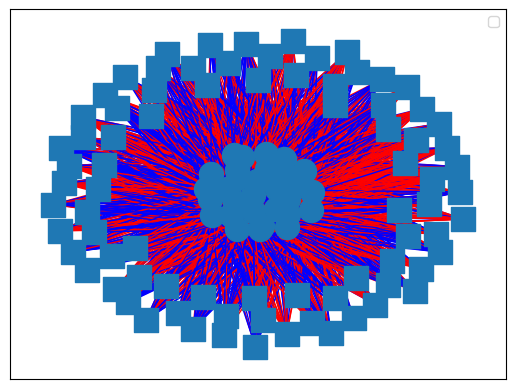

In [20]:
file_path = r"C:\Users\rishi\ml_projects\SBGNN\senators_votes_dataset.tsv"
B = load_graph(file_path)
set_a = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
set_b = [n for n, d in B.nodes(data=True) if d['bipartite'] == 1]
build_drawing(B,set_a,set_b)

In [21]:
sbgnn=SBGNN(B,32,32)
community=Community(sbgnn,2)
community.build_communities()
# print(community.C_a)

Epoch 0, Loss: 0.007624560635131743
Modularity : -0.00019193396773099937
Epoch 1, Loss: 0.26954026152430716
Modularity : -0.000590889434050695
Epoch 2, Loss: 0.048032710279266234
Modularity : 5.459679902876948e-05
Epoch 3, Loss: 0.062206427620081946
Modularity : -0.0003282430338422167
Epoch 4, Loss: 0.13616191232772606
Modularity : -0.0004594299507430405
Epoch 5, Loss: 0.07730758251950416
Modularity : 0.0002981436887983698
Epoch 6, Loss: 0.0017440883695713223
Modularity : 0.001951503910950642
Epoch 7, Loss: 0.025747175970444843
Modularity : 0.003422121394585536
Epoch 8, Loss: 0.06839597152704219
Modularity : 0.004967917589461414
Epoch 9, Loss: 0.053163625373033555
Modularity : 0.007797601735113664
Epoch 10, Loss: 0.0062214958539820505
Modularity : 0.012066461474836776
Epoch 11, Loss: -0.015294979640029242
Modularity : 0.01644650524662317
Epoch 12, Loss: 0.0002304286524137146
Modularity : 0.02035969117857841
Epoch 13, Loss: 0.009232095678045664
Modularity : 0.026109278960222145
Epoch 14

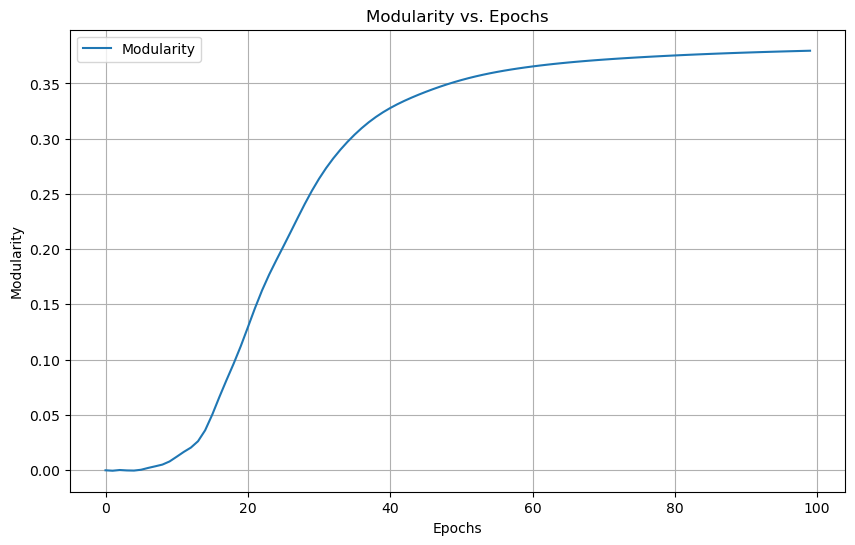

In [22]:
train_sbgnn(sbgnn,community)

In [23]:
tensor=community.C_a
for i in range(tensor.size(0)):
    # Find the index of the largest element in the row
    max_index = tensor[i].argmax().item()
    
    # Set all elements in the row to 0
    tensor[i].zero_()
    
    # Set the largest element in the row to 1
    tensor[i, max_index] = 1

for i, node in enumerate(set_a):
    if tensor[i][0] == 1:
        B.nodes[node]['assign'] = 0
    else:
        B.nodes[node]['assign'] = 1


In [24]:
tensor=community.C_b
for i in range(tensor.size(0)):
    # Find the index of the largest element in the row
    max_index = tensor[i].argmax().item()
    
    # Set all elements in the row to 0
    tensor[i].zero_()
    
    # Set the largest element in the row to 1
    tensor[i, max_index] = 1

for i, node in enumerate(set_b):
    if tensor[i][0] == 1:
        B.nodes[node]['assign'] = 0
    else:
        B.nodes[node]['assign'] = 1


C:\Users\rishi\AppData\Local\Temp\ipykernel_10792\1812424901.py:24: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(B, pos, edge_color=edge_colors)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


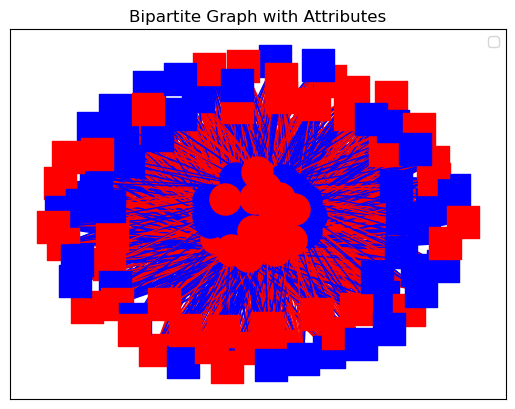

In [25]:
# Define shapes and colors based on attributes
shapes = ['o', 's']  # Circle for bipartite=0, Square for bipartite=1
colors = ['red', 'blue']  # Red for assign=0, Blue for assign=1

# Create a layout for the nodes
pos = nx.spring_layout(B)

# Draw nodes with different shapes and colors based on their attributes
for node in B:
    bipartite_attr = B.nodes[node]['bipartite']
    assign_attr = B.nodes[node].get('assign', 2)  # Default to 2 (green) if no 'assign' attribute
    shape = shapes[bipartite_attr]
    color = colors[assign_attr]
    
    nx.draw_networkx_nodes(
        B, pos, nodelist=[node], node_color=color, node_shape=shape, 
        node_size=500
    )

# Draw edges
edge_colors = ['blue' if attrs['sign'] == '+1' else 'red' for u, v, attrs in B.edges(data=True)]

# Draw edges with the determined colors
nx.draw_networkx_edges(B, pos, edge_color=edge_colors)

# Draw labels

# Display plot
plt.title("Bipartite Graph with Attributes")
plt.legend()
plt.show()
